In [1]:
# OPF-driven MPC
    # For Resiliency Improvement in (Islanded) Distribution Systems
    # Objective:
        # maximize the total /priority-weighted/ load (active and reactive) served
        # penalize restored load shedding
        # penalize wind and pv power curtailment
# The distribution grid model is written in Julia
# The MPC is written in Julia 
# The data analytics (pre/post-processing) and forecasts are written in Python
# The MPC calling is written in Python (this notebook)

# Multi-phase unbalanced distribution system

In [2]:
# Import required Python packages/modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sbn
#sbn.set()
from datetime import datetime
import os
import opendssdirect as dss
import math
import cmath

In [3]:
# Calling Julia Packages from Python
# Install Julia packages required by PyJulia

import julia
from julia.api import Julia
jl = Julia(compiled_modules=False)  
jl = julia.Julia()

In [4]:
# Include the Julia codes
    # Data preprocessing code
    # MPC code
    
jl.include("data_handler_multiphase2.jl");
jl.include("lr_multiphase_opf_mpc2.jl");


/Users/aeseye/.local/lib/python3.7/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


In [5]:
# Get the current directory

cur_dir = os.getcwd()

# Default/base network data (if any)

DATA_DIR = "basecase"


In [6]:
# Get the the distribution grid information to the MPC

NODES, LINES_SINGLE, LINES_MULTI, GENERATORS, WINDTURBINES, PVS, STORAGES = jl.load_case_data(datafile="13buscase")

BUSES = NODES


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [7]:
# Parameters

Δt = 5/60
SOC0 = 90

# Base values

Zbase = 1
Vbase = 2400
Sbase = (Vbase**2)/Zbase
Cbase = 800


In [8]:
# Exogenous data - wind and pv profiles - forecasts

# Forecast (Wind & PV) Reader 

# Change the current path to the exogenous data path
exo_data_path = os.chdir('data/exogenous_data')

class ForecastReader:
    def __init__(self, forecast_pointers_file='forecast_pointers.csv'):
        self._forecast_pointers = pd.read_csv(forecast_pointers_file, parse_dates=['Time'],
                                        index_col=0, infer_datetime_format=True).to_dict()['forecast_file']

    def get_forecast(self, datetime):
        '''
        Get the forecast as a pandas dataframe for the datetime
        '''
        k = pd.Timestamp(datetime)

        if k not in self._forecast_pointers:
            raise Exception(f"Datetime {datetime} does not have a forecast available")

        return pd.read_csv(self._forecast_pointers[k], parse_dates=['Time'], index_col=0, infer_datetime_format=True)

    def available_dates(self):
        return self._forecast_pointers.keys()

# Get the dates of interest (dates in the control horizon)

# Specify the starting point for the forecasts
    # 2019-08-03 12:00 for paper results
Start_index = 31*24*12 + 2*24*12 + 144      
#Start_index = 31*24*12 + 2*24*12 + 72       # 2019-08-03 06:00:00

# Define the optimization horizon (6 hours == 72 5-minutes)
num_time_steps = 12   # 72
dates_object = ForecastReader()
dates = dates_object.available_dates()
dateslist = list()
for time in dates:
    dateslist.append(time)
datetimes_6h = dateslist[Start_index:Start_index+num_time_steps]

# Get the PV and Wind forecasts
# and put together all the forecasts in all the time steps in the control horizon

# Define the rated capacities (kW) of the renewable generators
wind_mult = 50
pv_mult = 100

num_time_steps_in_a_day = 288
Pwind_forecast_all = np.empty((0, num_time_steps_in_a_day))
Psolar_forecast_all = np.empty((0, num_time_steps_in_a_day))

for datetime in datetimes_6h:
    # Read the Wind and PV Power Forecasts
    forecast_object = ForecastReader()
    forecast = forecast_object.get_forecast(datetime)
    Pwind = wind_mult*np.array(forecast['wind_gen'])
    Pwind_forecast_all = np.append(Pwind_forecast_all, [Pwind], axis=0)
    Psolar = pv_mult*np.array(forecast['pv_gen'])
    Psolar_forecast_all = np.append(Psolar_forecast_all, [Psolar], axis=0)
    

In [9]:
# Show the date and timestamps picked up

datetimes_6h

[Timestamp('2019-08-03 12:00:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:05:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:10:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:15:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:20:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:25:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:30:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:35:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:40:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:45:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:50:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:55:00+0000', tz='UTC')]

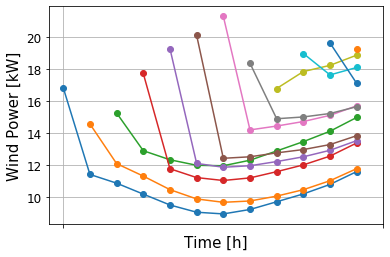

forecasted_wind_energy_kWh:  88.0181072229058


In [10]:
# Extract the Wind Forecasts at each time interval

forecasted_wind_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the wind at each step
    
    #wind = Pwind_forecast_all[idx, idx:72]
    wind = 3*Pwind_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_wind_energy = forecasted_wind_energy + sum(wind)*Δt
    
    plt.plot(T[idx:], wind, marker='o')
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Wind Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()
    
print('forecasted_wind_energy_kWh: ', forecasted_wind_energy)


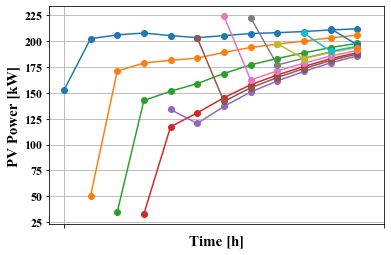

forecasted_solar_energy_kWh:  1147.2206000089354


In [11]:
# Extract the PV Forecasts at each time interval

forecasted_solar_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the PV power at each step
    
    pv = 3*Psolar_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_solar_energy = forecasted_solar_energy + sum(pv)*Δt

    plt.plot(T[idx:], pv, marker='o')
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('PV Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('forecasted_solar_energy_kWh: ', forecasted_solar_energy)


In [12]:
# Exogenous data - actual wind and pv profiles 

exo_data_path = cur_dir+"/five_min_renewable_profile.csv"

exo_data = pd.read_csv(exo_data_path, index_col=0)

start_idx = 0
duration = num_time_steps_in_a_day

wind_profile = exo_data["wind_gen"][start_idx:start_idx+duration]
pv_profile = exo_data["pv_gen"][start_idx:start_idx+duration]

wind_mult = 50
pv_mult = 100

wind = wind_mult * wind_profile
pv = pv_mult * pv_profile

Pwt = 1000 * wind /Sbase
Ppv = 1000 * pv /Sbase


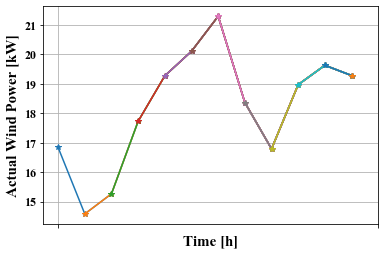

actual_wind_energy_kWh:  121.99765625


In [13]:
# Actual Wind power

starttime = "2019-08-03 12:00:00"
stoptime = "2019-08-03 18:00:00"

#starttime = "2019-08-03 06:00:00"
#stoptime = "2019-08-03 12:00:00"
            
wind1 = wind_mult*pd.DataFrame(exo_data[starttime:stoptime])['wind_gen']

actual_wind_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the wind at each step
    
    wind_act = 3*wind1[idx:num_time_steps]
    
    actual_wind_energy = actual_wind_energy + sum(wind_act)*Δt

    plt.plot(T[idx:], wind_act, marker='*')
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Actual Wind Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('actual_wind_energy_kWh: ', actual_wind_energy)


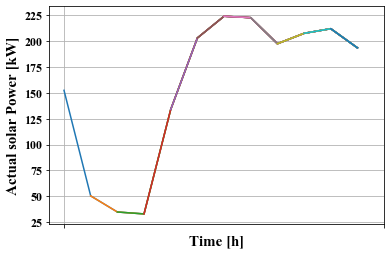

actual_solar_energy_kWh:  1186.3683127499999


In [14]:
# Actual solar power

pv1 = pv_mult*pd.DataFrame(exo_data[starttime:stoptime])['pv_gen']

actual_solar_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the wind at each step
    
    pv_act = 3*pv1[idx:num_time_steps]
    
    actual_solar_energy = actual_solar_energy + sum(pv_act)*Δt

    plt.plot(T[idx:], pv_act)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Actual solar Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('actual_solar_energy_kWh: ', actual_solar_energy)


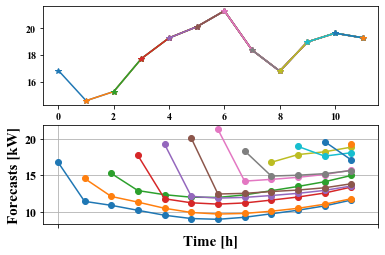

actual_wind_energy_kWh:  121.99765625
forecasted_wind_energy_kWh:  88.0181072229058


In [15]:
# Wind Actual vs Forecast

# Actual Wind power

wind1 = wind_mult*pd.DataFrame(exo_data[starttime:stoptime])['wind_gen']

actual_wind_energy = 0 
forecasted_wind_energy = 0 
T = range(num_time_steps)
fig, axs = plt.subplots(2, 1) 
for idx in T:

    # Update the wind at each step
    
    wind_act = 3*wind1[idx:num_time_steps]
    
    actual_wind_energy = actual_wind_energy + sum(wind_act)*Δt
    
    wind = 3*Pwind_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_wind_energy = forecasted_wind_energy + sum(wind)*Δt

    #plt.plot(T[idx:], wind_act, marker='*')
    axs[0].plot(T[idx:], wind_act, marker='*')
    plt.ylabel('Actuals [kW]', fontsize=15)
    #plt.plot(T[idx:], wind, marker='o')
    axs[1].plot(T[idx:], wind, marker='o') 
    plt.ylabel('Forecasts [kW]', fontsize=15)
    
plt.xlabel('Time [h]', fontsize=15)
#plt.ylabel('Forecasts [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('actual_wind_energy_kWh: ', actual_wind_energy)
    
print('forecasted_wind_energy_kWh: ', forecasted_wind_energy)


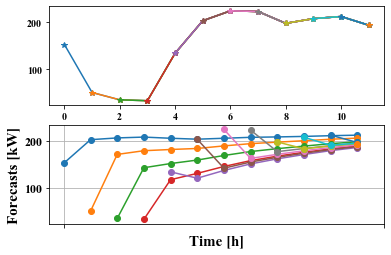

actual_solar_energy_kWh:  1186.3683127499999
forecasted_solar_energy_kWh:  1147.2206000089354


In [16]:
# Solar Actual vs Forecast

starttime = "2019-08-03 12:00:00"
stoptime = "2019-08-03 18:00:00"
pv1 = pv_mult*pd.DataFrame(exo_data[starttime:stoptime])['pv_gen']

actual_solar_energy = 0 
forecasted_solar_energy = 0 
T = range(num_time_steps)
fig, axs = plt.subplots(2, 1) 
for idx in T:

    # Update the wind at each step
    
    pv_act = 3*pv1[idx:num_time_steps]
    
    actual_solar_energy = actual_solar_energy + sum(pv_act)*Δt
    
    pv = 3*Psolar_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_solar_energy = forecasted_solar_energy + sum(pv)*Δt

    #plt.plot(T[idx:], wind_act, marker='*')
    axs[0].plot(T[idx:], pv_act, marker='*')
    plt.ylabel('Actuals [kW]', fontsize=15)
    #plt.plot(T[idx:], wind, marker='o')
    axs[1].plot(T[idx:], pv, marker='o') 
    plt.ylabel('Forecasts [kW]', fontsize=15)
    
plt.xlabel('Time [h]', fontsize=15)
#plt.ylabel('Forecasts [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('actual_solar_energy_kWh: ', actual_solar_energy)
    
print('forecasted_solar_energy_kWh: ', forecasted_solar_energy)



In [17]:
# Load demand time series in per unit (pu)

d_P = np.zeros((len(BUSES), num_time_steps_in_a_day))
d_Q = np.zeros((len(BUSES), num_time_steps_in_a_day))
for b in jl.keys(BUSES):
    for t in range(num_time_steps_in_a_day):
        if b == 7-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 8-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 9-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 10-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 11-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 12-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q     
        if b == 19-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 20-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 21-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 23-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 25-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 26-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q 
        if b == 27-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 28-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 29-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 30-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 31-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 34-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q
        if b == 35-1:
            d_P[b,t] = BUSES[b+1].d_P
            d_Q[b,t] = BUSES[b+1].d_Q

Pd = d_P       # active_power_demand
Qd = d_Q;      # reactive_power_demand

# Total active power demand at each time step

P_d_tot = np.zeros((num_time_steps_in_a_day))
for jdx in range(num_time_steps_in_a_day):
    P_d_tot[jdx] = np.sum(Pd[:,jdx]) 


Q_d_tot = np.zeros((num_time_steps_in_a_day))
for jdx in range(num_time_steps_in_a_day):
    Q_d_tot[jdx] = np.sum(Qd[:,jdx]) 

# Number of buses

num_buses = len(BUSES)

# Number of load buses

load_buses = jl.findall(Pd[:,0] != 0.0)
num_load_buses = len(load_buses)


In [18]:
# Inputs to MPC

es_soc = [90, 90, 90]
mt_energy = 1000
active_power_demanded = Pd
reactive_power_demanded = Qd
active_power_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
reactive_power_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

num_buses = len(BUSES)
num_lines = len(LINES_SINGLE)

# // Set array to store the MPC results

Pmtt = ([])
Qmtt = ([])

#Pess = ([])
#Pess = np.empty((0, 3))

Pess1 = ([])
Pess2 = ([])
Pess3 = ([])

#Qess = ([])
#Qess = np.empty((0, 3))

Qess1 = ([])
Qess2 = ([])
Qess3 = ([])

#SOCes = ([])
#SOCes = np.empty((0, 3))

SOCes1 = ([])
SOCes2 = ([])
SOCes3 = ([])

Pwt_instant = ([])
Pwt_cutt = ([])
Qwt_invv1 = ([])
Qwt_invv2 = ([])
Qwt_invv3 = ([])

Ppv_instant = ([])
Ppv_cutt = ([])
Qpv_invv1 = ([])
Qpv_invv2 = ([])
Qpv_invv3 = ([])

Pd_instant = np.empty((0, num_buses))
Qd_instant = np.empty((0, num_buses))
P_restoredd = np.empty((0, num_buses))
Q_restoredd = np.empty((0, num_buses))

mu_PP = np.empty((0, num_buses))
mu_QQ = np.empty((0, num_buses))

Pwt_instant = ([])
Ppv_instant = ([])

from_node = np.empty((num_lines))
to_node = np.empty((num_lines))
P_line = np.empty((0, num_lines))
Q_line = np.empty((0, num_lines))

volts_mpc = np.empty((0, num_buses))

# Initial control horizon

control_horizon = num_time_steps

# Call the MPC

for i in range(num_time_steps):

    # Update the wind and PV power at each step
    
    wt_power = 1000*Pwind_forecast_all[i, 0:72]/Sbase
    pv_power = 1000*Psolar_forecast_all[i, 0:72]/Sbase
    
    objective_value, P_restored, Q_restored, Pmt, Qmt, Pwtb, Pwt_cut,\
    Qwt_inv_ph1, Qwt_inv_ph2, Qwt_inv_ph3, Ppvs, Ppv_cut, Qpv_inv_ph1,\
    Qpv_inv_ph2, Qpv_inv_ph3, Pes1, Pes2, Pes3, Qes1, Qes2, Qes3,\
    SOC_es1, SOC_es2, SOC_es3, voltages, mu_P, mu_Q, fromnode, tonode, Plineflow, Qlineflow =\
    jl.opf_mpc(BUSES, LINES_SINGLE, LINES_MULTI, GENERATORS, WINDTURBINES, PVS, STORAGES, control_horizon, es_soc, mt_energy,\
                 wt_power, pv_power, active_power_demanded, reactive_power_demanded,
                 active_power_restored, reactive_power_restored)
  
    # Apply the first control actions and discard the rest
    
    P_restoredd = np.append(P_restoredd, [P_restored[:,0]], axis=0)
    Q_restoredd = np.append(Q_restoredd, [Q_restored[:,0]], axis=0)
    
    mu_PP = np.append(mu_PP, [mu_P[:,0]], axis=0)
    mu_QQ = np.append(mu_QQ, [mu_Q[:,0]], axis=0)
    
    Pmtt = np.append(Pmtt, Pmt[0]) 
    Qmtt = np.append(Qmtt, Pmt[0])
    
    #Pess = np.append(Pess, Pes[0])
    #Pess = np.append(Pess, [Pes[:,0]], axis=0)
    
    Pess1 = np.append(Pess1, Pes1[0])
    Pess2 = np.append(Pess2, Pes2[0])
    Pess3 = np.append(Pess3, Pes3[0])
    
    #Qess = np.append(Pess, Qes[0])
    #Qess = np.append(Qess, [Qes[:,0]], axis=0)
    
    Qess1 = np.append(Qess1, Qes1[0])
    Qess2 = np.append(Qess2, Qes2[0])
    Qess3 = np.append(Qess3, Qes3[0])
    
    #SOCes = np.append(SOCes, SOC_es[0])
    #SOCes = np.append(SOCes, [SOC_es[:,0]], axis=0)
    
    SOCes1 = np.append(SOCes1, SOC_es1[0])
    SOCes2 = np.append(SOCes2, SOC_es2[0])
    SOCes3 = np.append(SOCes3, SOC_es3[0])
    
    Pwt_cutt = np.append(Pwt_cutt, Pwt_cut[0])
    Qwt_invv1 = np.append(Qwt_invv1, Qwt_inv_ph1[0])
    Qwt_invv2 = np.append(Qwt_invv2, Qwt_inv_ph2[0])
    Qwt_invv3 = np.append(Qwt_invv3, Qwt_inv_ph3[0])
                         
    Ppv_cutt = np.append(Ppv_cutt, Ppv_cut[0])
    Qpv_invv1 = np.append(Qpv_invv1, Qpv_inv_ph1[0])
    Qpv_invv2 = np.append(Qpv_invv2, Qpv_inv_ph2[0])
    Qpv_invv3 = np.append(Qpv_invv3, Qpv_inv_ph3[0])
  
    P_line = np.append(P_line, [Plineflow[:,0]], axis=0)
    Q_line = np.append(Q_line, [Qlineflow[:,0]], axis=0)
    
    #from_node = np.append(from_node, fromnode)
    #to_node = np.append(to_node, tonode)
    
    volts_mpc = np.append(volts_mpc, [voltages[:,0]], axis=0)
    
    # Save the intant (current) values of the loads and RE generations 
        
    Pd_instant = np.append(Pd_instant, [active_power_demanded[:,0]], axis=0)
    Qd_instant = np.append(Qd_instant, [reactive_power_demanded[:,0]], axis=0)
    Pwt_instant = np.append(Pwt_instant, Pwtb[0])
    Ppv_instant = np.append(Ppv_instant, Ppvs[0])
       
    # Update the ES SOC and MT fuel status for the next step
    
    #es_soc = SOC_es[0]
    #es_soc = SOC_es[:,0]
    es_soc = [SOC_es1[0], SOC_es2[0], SOC_es3[0]]
    mt_energy = mt_energy - Pmt[0]*Δt
    
    # Update the restored load for the next step
    
    active_power_restored = np.transpose(P_restored)[0]*1000/Sbase
    reactive_power_restored = np.transpose(Q_restored)[0]*1000/Sbase
    
    # Update (reduce) the control horizon for the next step
    
    control_horizon -=1
        
# END

Pd_instant = np.transpose(Pd_instant)
Qd_instant = np.transpose(Qd_instant)
P_restoredd = np.transpose(P_restoredd)
Q_restoredd = np.transpose(Q_restoredd)
volts_mpc = np.transpose(volts_mpc)
P_line = np.transpose(P_line)
Q_line = np.transpose(Q_line)
#from_node = from_node[:num_lines]
#to_node = to_node[:num_lines]

#Pess = np.transpose(Pess)
#Qess = np.transpose(Qess)
#SOCes = np.transpose(SOCes)

mu_PP = np.transpose(mu_PP)
mu_QQ = np.transpose(mu_QQ)


In [19]:
# Demanded power at each time step

P_demanded_t = ([])
for pdx in range(Pd_instant.shape[1]):
    P_demanded_t.append(sum(Pd_instant[:,pdx])*Sbase/1000)
    
Q_demanded_t = ([])
for qdx in range(Qd_instant.shape[1]):
    Q_demanded_t.append(sum(Qd_instant[:,qdx])*Sbase/1000)

# Restored load at each time step

P_restored_t = ([])
Q_restored_t = ([])
for jdx in range(num_time_steps):
    P_restored_t = np.append(P_restored_t, sum(P_restoredd[:,jdx]))
    Q_restored_t = np.append(Q_restored_t, sum(Q_restoredd[:,jdx]))
    
# Restored energy at each node

E_restored_n = ([])
for qdx in range(num_buses):
    E_restored_n = np.append(E_restored_n, sum(P_restoredd[qdx,:])*Δt)
    

In [20]:
# Demanded vs restored energy

demanded_energy = sum(P_demanded_t)*Δt
restored_energy = sum(P_restored_t)*Δt
print("demanded vs restored energy in kWh: ", demanded_energy, ", ", restored_energy)


demanded vs restored energy in kWh:  1207.4899999999998 ,  652.1478858226075


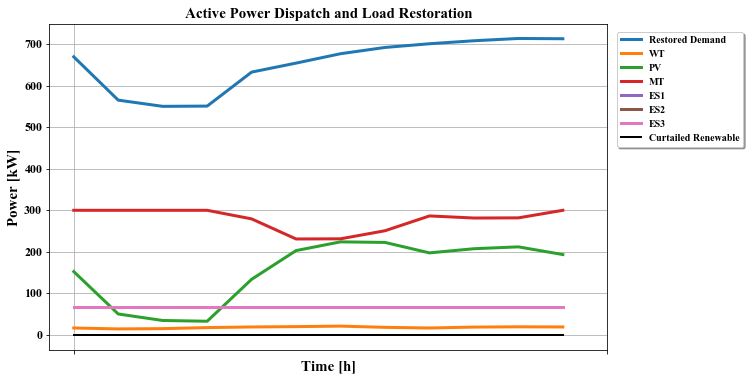

In [21]:
# Result Plots

# Active Power (kW)

plt.figure(figsize=(10,6))
#plt.plot(P_demanded_t, label='Requested Demand', linewidth = 3)
plt.plot(P_restored_t, label='Restored Demand', linewidth = 3)
plt.plot(Pwt_instant, label='WT', linewidth = 3)
plt.plot(Ppv_instant, label='PV', linewidth = 3)
plt.plot(Pmtt, label='MT', linewidth = 3)
#plt.plot(Pess, label='ES', linewidth = 3)
plt.plot(Pess1, label='ES1', linewidth = 3)
plt.plot(Pess2, label='ES2', linewidth = 3)
plt.plot(Pess3, label='ES3', linewidth = 3)
plt.plot((Pwt_cutt + Ppv_cutt), label='Curtailed Renewable', linewidth = 2, color = 'black')

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kW]', fontsize=15)
plt.title('Active Power Dispatch and Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.13, 0.99), fancybox=True, shadow=True, ncol=1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()


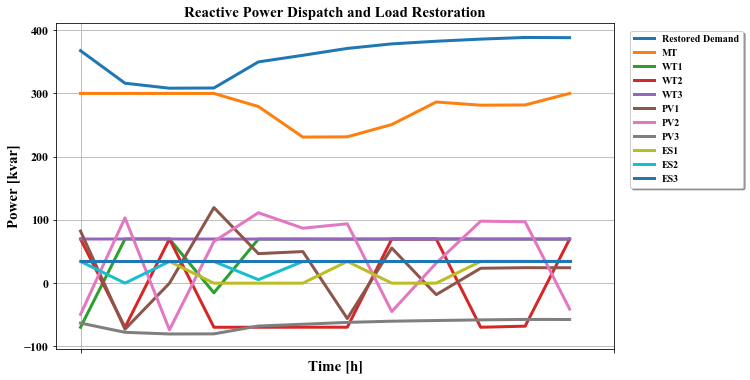

In [22]:
# Result Plots

# Reactive Power (kvar)

plt.figure(figsize=(10,6))
#plt.plot(Q_demanded_t, label='Requested Demand', linewidth = 3)
plt.plot(Q_restored_t, label='Restored Demand', linewidth = 3)
#plt.plot(Qwt_invv, label='WT', linewidth = 3)
#plt.plot(Qpv_invv, label='PV', linewidth = 3)
plt.plot(Qmtt, label='MT', linewidth = 3)

plt.plot(Qwt_invv1, label='WT1', linewidth = 3)
plt.plot(Qwt_invv2, label='WT2', linewidth = 3)
plt.plot(Qwt_invv3, label='WT3', linewidth = 3)

plt.plot(Qpv_invv1, label='PV1', linewidth = 3)
plt.plot(Qpv_invv2, label='PV2', linewidth = 3)
plt.plot(Qpv_invv3, label='PV3', linewidth = 3)

#plt.plot(Qess, label='ES', linewidth = 3)
plt.plot(Qess1, label='ES1', linewidth = 3)
plt.plot(Qess2, label='ES2', linewidth = 3)
plt.plot(Qess3, label='ES3', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kvar]', fontsize=15)
plt.title('Reactive Power Dispatch and Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.13, 0.99), fancybox=True, shadow=True, ncol=1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()


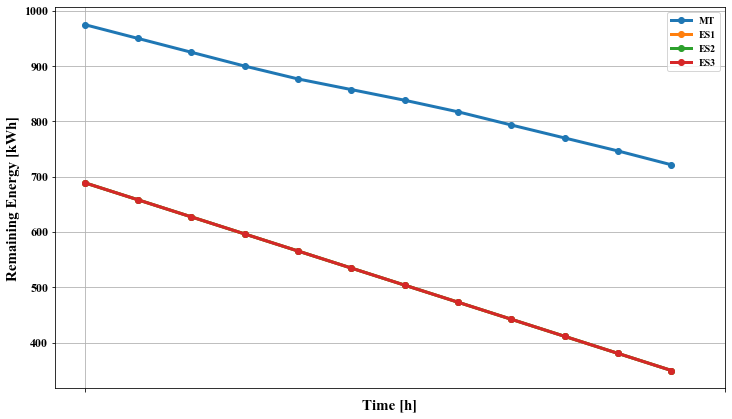

In [23]:
# Change in Energy of ES and MT

Emt_gen = ([])
Emt_gen = np.append(Emt_gen, 1000 - Pmtt[0]*Δt)
for v in range(1,num_time_steps):
    Emt_gen = np.append(Emt_gen, Emt_gen[v-1] - Pmtt[v]*Δt)

plt.figure(figsize=(12,7))
plt.plot(Emt_gen, label='MT', linewidth = 3, marker='o')
#plt.plot(800*SOCes/100, label='ES', linewidth = 3, marker='o')
plt.plot(800*SOCes1/100, label='ES1', linewidth = 3, marker='o')
plt.plot(800*SOCes2/100, label='ES2', linewidth = 3, marker='o')
plt.plot(800*SOCes3/100, label='ES3', linewidth = 3, marker='o')
plt.xlabel('Time [h]', fontsize=15)
#plt.ylim((-10, 1050))
plt.ylabel('Remaining Energy [kWh]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()


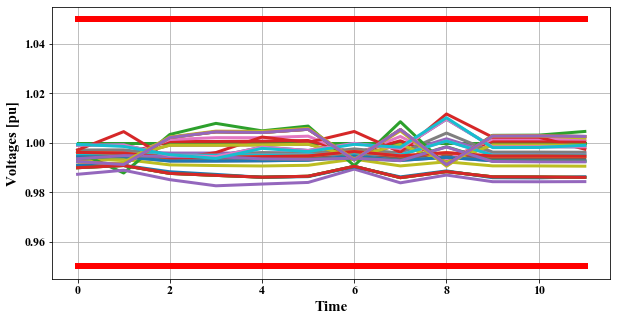

In [24]:
# Voltage Profiles

# ANSI voltage regulation limits (0.95, 1.05)

lower_vol_limit = 0.95
upper_vol_limit = 1.05
lb_volts = ([])
ub_volts = ([])
for j in range(num_time_steps):
    lb_volts = np.append(lb_volts, lower_vol_limit)
    ub_volts = np.append(ub_volts, upper_vol_limit)
    
#Buses = ['Bus1','Bus2','Bus3','Bus4','Bus5','Bus6','Bus7','Bus8','Bus9','Bus10','Bus11','Bus12','Bus13']

plt.figure(figsize=(10,5))
for bx in range(len(volts_mpc)):
    #plt.plot(volts[bx], label = Buses[bx], linewidth = 3)
    plt.plot(volts_mpc[bx], linewidth = 3)  # label = nodes[k]
plt.plot(lb_volts, linewidth = 6, color="red")
plt.plot(ub_volts, linewidth = 6, color="red")
plt.xlabel('Time', fontsize=15)
plt.ylabel('Voltages [pu]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, num_time_steps+1, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*num_time_steps, 12)])
plt.rcParams["font.family"] = "Times New Roman"
#plt.ylim((0.94, 1.06))
plt.grid()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.show()


In [25]:
# Line flows - MPC

P_flow_kW = {}
Q_flow_kvar = {}

P_flow_kW2 = {}
Q_flow_kvar2 = {}

i = 0
for n in range(len(fromnode)):
    P_flow_kW[fromnode[n], tonode[n]] = P_line[n]
    Q_flow_kvar[fromnode[n], tonode[n]] = Q_line[n]
    P_flow_kW2[n+1] = P_line[n]
    Q_flow_kvar2[n+1] = Q_line[n]
    i+=1
    
P_flow_kW_mpc = P_line
Q_flow_kvar_mpc = Q_line

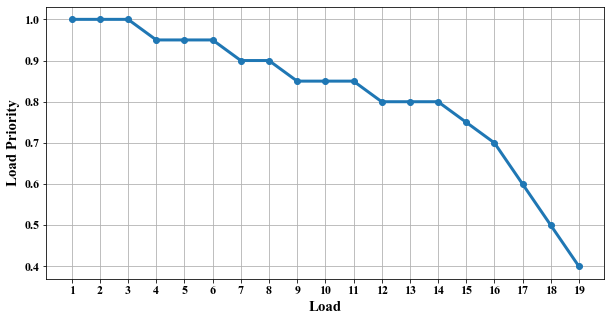

In [26]:
# Plot the Load Priority Weight

#load_priority_weight = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3]

load_priority = [1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.90, 0.90, 0.85,
                0.85, 0.85, 0.8, 0.8, 0.8, 0.75, 0.70, 0.6, 0.5, 0.4]

#node_idx = range(num_load_buses)
#node_idx = np.array(node_idx)
plt.figure(figsize=(10,5))
plt.plot(load_priority, linewidth = 3, marker="o")
plt.xlabel('Load', fontsize=15)
plt.ylabel('Load Priority', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 19, 1), [str(int(c)) for c in range(1, 20, 1)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


In [27]:
# OpenDSS Simulation
    # Based on the MPC's DER power set-points and picked up loads

In [28]:
# Get the DER set-points

Pmt_sp = Pmtt
Ppv_sp = Ppv_instant - Ppv_cutt
Pwt_sp = Pwt_instant - Pwt_cutt
Pes1_sp = Pess1
Pes2_sp = Pess2
Pes3_sp = Pess3

Qmt_sp = Qmtt

Qwt1_sp = Qwt_invv1
Qwt2_sp = Qwt_invv2
Qwt3_sp = Qwt_invv3

Qpv1_sp = Qpv_invv1
Qpv2_sp = Qpv_invv2
Qpv3_sp = Qpv_invv3

Qes1_sp = Qess1
Qes2_sp = Qess2
Qes3_sp = Qess3

In [29]:
# Get the restored loads and connect them to the feeder nodes in the dss

# Path of the feeder dss model

masterfile = cur_dir+"/data/network_data/ieee_13node_DSS/master_islanded3.dss"
#masterfile = cur_dir+"/data/network_data/ieee_13node_DSS/master_islanded3_without_load.dss"

# Run the dss

str_cmd = 'Compile {}'.format(masterfile)
dss.run_command(str_cmd)

# Get the loads in the order of the systemY/Ybus matrix

AllNodeNamesY = dss.Circuit.YNodeOrder()

# Demanded loads 

demanded_load_kW = Pd_instant*Sbase/1000
demanded_load_kvar = Qd_instant*Sbase/1000

# Restored loads by the MPC

restored_load_kW = P_restoredd
restored_load_kvar = Q_restoredd

# Update the dss loads with the restored loads

ld = dss.Loads.First()
while(ld):
    i=0
    load_name = dss.Loads.Name()
    if load_name == '671':
        p = sum(restored_load_kW[9:12,i])
        q = sum(restored_load_kvar[9:12,i])
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '634a':
        p = restored_load_kW[18,i]
        q = restored_load_kvar[18,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '634b':
        p = restored_load_kW[19,i]
        q = restored_load_kvar[19,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '634c':
        p = restored_load_kW[20,i]
        q = restored_load_kvar[20,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '645':
        p = restored_load_kW[22,i]
        q = restored_load_kvar[22,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '646':
        p = restored_load_kW[24,i]
        q = restored_load_kvar[24,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '692':
        p = sum(restored_load_kW[25:28,i])
        q = sum(restored_load_kvar[25:28,i])
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '675a':
        p = restored_load_kW[28,i]
        q = restored_load_kvar[28,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '675b':
        p = restored_load_kW[29,i]
        q = restored_load_kvar[29,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '675c':
        p = restored_load_kW[30,i]
        q = restored_load_kvar[30,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '611':
        p = restored_load_kW[33,i]
        q = restored_load_kvar[33,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q) 
    if load_name == '652':
        p = restored_load_kW[34,i]
        q = restored_load_kvar[34,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)  
    if load_name == '670a':
        p = restored_load_kW[6,i]
        q = restored_load_kvar[6,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '670b':
        p = restored_load_kW[7,i]
        q = restored_load_kvar[7,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    if load_name == '670c':
        p = restored_load_kW[8,i]
        q = restored_load_kvar[8,i]
        dss.Loads.kW(p)
        dss.Loads.kvar(q)
    ld = dss.Loads.Next()
    
# Get the load node details (name, demand, ...)

load_dict = []
ld = dss.Loads.First()

while(ld):
    #print(dss.Loads.Name(), flush=True)
    dss.Circuit.SetActiveElement(dss.Loads.Name())
    load_dict.append({'loadname' : dss.Loads.Name() , 'busname' :   dss.CktElement.BusNames()[0], \
                        'phases' : [int(x) for x in dss.CktElement.BusNames()[0].split('.')[1:]], \
                        'p' : dss.Loads.kW(),
                        'q' : dss.Loads.kvar(),
                        'pf' : dss.Loads.PF(),
                        'nodename' : dss.CktElement.BusNames()[0].split(".")[0].upper()
    })
    ld = dss.Loads.Next()
    
#load_dict

In [30]:
# Aggregate restored load connected to dss

ld = dss.Loads.First()
kWsum = 0.0
kvarsum = 0.0
while ld > 0:
    kWsum += dss.Loads.kW()
    kvarsum += dss.Loads.kvar()
    ld = dss.Loads.Next()

print("Aggregate restored load kW & kvar: ", kWsum, kvarsum)

Aggregate restored load kW & kvar:  669.3166358999999 367.5836141965517


In [31]:
# Aggregate power production

Pgen = Pmt_sp + Ppv_sp + Pwt_sp + Pes1_sp + Pes2_sp + Pes3_sp
Qgen = Qmt_sp + Qwt1_sp + Qwt2_sp + Qwt3_sp + Qpv1_sp + Qpv2_sp + Qpv3_sp + Qes1_sp + Qes2_sp + Qes3_sp 

print("Aggregate generation kW & kvar: ", Pgen[0], Qgen[0])

Aggregate generation kW & kvar:  669.3166358999998 442.5836141965519


In [32]:
# Voltage function which returns nodal voltage magnitudes from complex voltages
    # Vol_Y contains real and image part

def Voltage(Vol_Y, NodeNum):
    Vmag = [0]*NodeNum
    for i in range(NodeNum):
        Vmag[i] = math.sqrt(Vol_Y[2*i]**2 + Vol_Y[2*i+1]**2)
    return Vmag

In [33]:
# Node names

nodeNamesCsv = ['650.1','650.2','650.3','632.1','632.2','632.3','670.1','670.2','670.3','671.1','671.2',\
                '671.3','680.1','680.2','680.3','633.1','633.2','633.3','634.1','634.2','634.3','645.3',\
                '645.2','646.3','646.2','692.1','692.2','692.3','675.1','675.2','675.3','684.1','684.3',\
                '611.3','652.1']

NameToIndexCsv = {}

j=1
for name in nodeNamesCsv:
    NameToIndexCsv[name] = j
    j+=1

In [34]:
# Run the OpenDSS simulation with the MPC's DERs set-points and restored loads

volts_dss = np.empty((0, num_buses))
P_flow_kW_dss = np.zeros((num_lines, num_time_steps))
Q_flow_kW_dss = np.zeros((num_lines, num_time_steps))
line_lossesP = ([])
line_lossesQ = ([])
slackP = ([])
slackQ = ([])

for i in range(num_time_steps):
     
    # Update the dss loads with the MPC restored loads

    ld = dss.Loads.First()
    while(ld):
        load_name = dss.Loads.Name()
        if load_name == '671':
            p = sum(restored_load_kW[9:12,i])
            q = sum(restored_load_kvar[9:12,i])
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '634a':
            p = restored_load_kW[18,i]
            q = restored_load_kvar[18,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '634b':
            p = restored_load_kW[19,i]
            q = restored_load_kvar[19,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '634c':
            p = restored_load_kW[20,i]
            q = restored_load_kvar[20,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '645':
            p = restored_load_kW[22,i]
            q = restored_load_kvar[22,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '646':
            p = restored_load_kW[24,i]
            q = restored_load_kvar[24,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '692':
            p = sum(restored_load_kW[25:28,i])
            q = sum(restored_load_kvar[25:28,i])
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '675a':
            p = restored_load_kW[28,i]
            q = restored_load_kvar[28,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '675b':
            p = restored_load_kW[29,i]
            q = restored_load_kvar[29,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '675c':
            p = restored_load_kW[30,i]
            q = restored_load_kvar[30,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '611':
            p = restored_load_kW[33,i]
            q = restored_load_kvar[33,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q) 
        if load_name == '652':
            p = restored_load_kW[34,i]
            q = restored_load_kvar[34,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)  
        if load_name == '670a':
            p = restored_load_kW[6,i]
            q = restored_load_kvar[6,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '670b':
            p = restored_load_kW[7,i]
            q = restored_load_kvar[7,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '670c':
            p = restored_load_kW[8,i]
            q = restored_load_kvar[8,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        ld = dss.Loads.Next()
        
    # Add the MPC DER set-points

        # MT at node 650

    dss.run_command(
        "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
        model=1 conn=wye".format(
        gen_name='MT',
        bus_name='650.1.2.3',
        active_pwr=Pmt_sp[i],  
        reac_pwr=Qmt_sp[i]
        ))

    dss.run_command(
        "New Vsource.{vs_name} Bus1={bus_name} phases=3 basekv=4.16 angle=30\
        baseMVA=np.sqrt((Pmt_sp[i]/1000)**2 + (Qmt_sp[i]/1000)**2)\
        MVAsc3=np.sqrt((Pmt_sp[i]/1000)**2 + (Qmt_sp[i]/1000)**2)\
        MVAsc1=(np.sqrt((Pmt_sp[i]/1000)**2 + (Qmt_sp[i]/1000)**2))/3 pu=1.0 enabled=y ".format(
        vs_name='VS_MT',
        bus_name='650.1.2.3'
        ))

        # PV at node 680

    dss.run_command(
        "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
        model=1 conn=wye".format(
        gen_name='PV',
        bus_name='680.1.2.3',
        active_pwr=Ppv_sp[i],  
        reac_pwr=(Qpv1_sp[i] + Qpv2_sp[i] + Qpv3_sp[i])
        ))

        # Wind Turbine (WT) at node 675

    dss.run_command(
        "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
        model=1 conn=wye".format(
        gen_name='WT',
        bus_name='675.1.2.3',
        active_pwr=Pwt_sp[i],  
        reac_pwr=(Qwt1_sp[i] + Qwt2_sp[i] + Qwt3_sp[i])
        ))

        # Energy Storage (ES) at node 632
        
    if Pes1_sp[i] > 0:
        dss.run_command(
            "New Generator.{gen_name} Bus1={bus_name} phase=1 kV=2.4 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            gen_name='ES1',
            bus_name='632.1',
            active_pwr=Pes1_sp[i],  
            reac_pwr=Qes1_sp[i]
            ))
    else:
        dss.run_command(
            "New Load.{load_name} Bus1={bus_name} phase=1 kV=2.4 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            load_name='ES1',
            bus_name='632.1',
            active_pwr=-Pes1_sp[i],  
            reac_pwr=0.0
            ))
    if Pes2_sp[i] > 0:
        dss.run_command(
            "New Generator.{gen_name} Bus1={bus_name} phase=1 kV=2.4 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            gen_name='ES2',
            bus_name='632.2',
            active_pwr=Pes2_sp[i],  
            reac_pwr=Qes2_sp[i]
            ))
    else:
        dss.run_command(
            "New Load.{load_name} Bus1={bus_name} phase=1 kV=2.4 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            load_name='ES2',
            bus_name='632.2',
            active_pwr=-Pes2_sp[i],  
            reac_pwr=0.0
            ))
    if Pes3_sp[i] > 0:
        dss.run_command(
            "New Generator.{gen_name} Bus1={bus_name} phase=1 kV=2.4 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            gen_name='ES3',
            bus_name='632.3',
            active_pwr=Pes3_sp[i],  
            reac_pwr=Qes3_sp[i]
            ))
    else:
        dss.run_command(
            "New Load.{load_name} Bus1={bus_name} phase=1 kV=2.4 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            load_name='ES3',
            bus_name='632.3',
            active_pwr=-Pes3_sp[i],  
            reac_pwr=0.0
            ))
        
    # Solve the power flow using the DSS

    dss.run_command('Solve mode=snap');
      
    # Voltage profiles at each node at the current time step

    #voltages = dss.Circuit.AllBusMagPu()
    voltages = dss.Circuit.YNodeVArray()
    NodeNum = len(voltages)/2  #38
    Vmag = np.array(Voltage(voltages, 38))/Vbase
    Vmag = Vmag[3:]
    
    volts_dss = np.append(volts_dss, [Vmag], axis=0)
    
    # Total line loss
    
    Sloss = dss.Circuit.LineLosses()
    Ploss = Sloss[0]
    Qloss = Sloss[1]
    line_lossesP = np.append(line_lossesP, Ploss)
    line_lossesQ = np.append(line_lossesQ, Qloss)
    
    # Power from the slack source (Vsource)
    
    Sslack = dss.Circuit.TotalPower()
    Pslack = Sslack[0]
    Qslack = Sslack[1]
    slackP = np.append(slackP, Pslack)
    slackQ = np.append(slackQ, Qslack)
    
    # Power flow through each line
    
    pwr_flow_kW_dss = {}
    pwr_flow_kvar_dss = {}

    for element in dss.Circuit.AllElementNames():
        if element[0:4] == 'Line':
            dss.Circuit.SetActiveElement(element)
            line = dss.CktElement.Name()
            fromb = line[5:8]
            tob = line[8:]
            lineflow = dss.CktElement.Powers()

            if len(lineflow)/4 == 3:
                if (fromb+'.1') in nodeNamesCsv and (tob+'.1') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.1']
                    tob_nodeindex = NameToIndexCsv[tob+'.1']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[0]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[1]
                if (fromb+'.2') in nodeNamesCsv and (tob+'.2') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.2']
                    tob_nodeindex = NameToIndexCsv[tob+'.2']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[2]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[3]
                if (fromb+'.3') in nodeNamesCsv and (tob+'.3') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.3']
                    tob_nodeindex = NameToIndexCsv[tob+'.3']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[4]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[5]

            if len(lineflow)/4 == 2:
                if (fromb+'.1') in nodeNamesCsv and (tob+'.1') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.1']
                    tob_nodeindex = NameToIndexCsv[tob+'.1']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[0]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[1]
                if (fromb+'.2') in nodeNamesCsv and (tob+'.2') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.2']
                    tob_nodeindex = NameToIndexCsv[tob+'.2']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    if (fromb+'.1') and (tob+'.1') in nodeNamesCsv:
                        P_flow_kW_dss[tob_nodelineindex+1] = lineflow[2]
                        Q_flow_kvar_dss[tob_nodelineindex+1] = lineflow[3]
                    else:
                        pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[0]
                        pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[1]
                if (fromb+'.3') in nodeNamesCsv and (tob+'.3') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.3']
                    tob_nodeindex = NameToIndexCsv[tob+'.3']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[2]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[3]
            if len(lineflow)/4 == 1:
                if (fromb+'.1') in nodeNamesCsv and (tob+'.1') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.1']
                    tob_nodeindex = NameToIndexCsv[tob+'.1']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[0]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[1]
                if (fromb+'.2') in nodeNamesCsv and (tob+'.2') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.2']
                    tob_nodeindex = NameToIndexCsv[tob+'.2']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[0]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[1]
                if (fromb+'.3') in nodeNamesCsv and (tob+'.3') in nodeNamesCsv:
                    fromb_nodeindex = NameToIndexCsv[fromb+'.3']
                    tob_nodeindex = NameToIndexCsv[tob+'.3']
                    fromb_nodelineindex = np.where(fromnode == fromb_nodeindex)[0][0]
                    tob_nodelineindex = np.where(tonode == tob_nodeindex)[0][0]
                    pwr_flow_kW_dss[tob_nodelineindex+1] = lineflow[0]
                    pwr_flow_kvar_dss[tob_nodelineindex+1] = lineflow[1]

    pwr_flow_kW_dss_sorted = ([])
    pwr_flow_kvar_dss_sorted = ([])
    for l in range(num_lines):
        pwr_flow_kW_dss_sorted.append(pwr_flow_kW_dss[l+1])
        pwr_flow_kvar_dss_sorted.append(pwr_flow_kvar_dss[l+1])
    pwr_flow_kW_dss_sorted = np.array(pwr_flow_kW_dss_sorted)
    pwr_flow_kvar_dss_sorted = np.array(pwr_flow_kvar_dss_sorted)
    
    P_flow_kW_dss[:,i] = pwr_flow_kW_dss_sorted
    Q_flow_kW_dss[:,i] = pwr_flow_kvar_dss_sorted
    
# Voltage profiles at each node for the whole simulation step
  
volts_dss = np.transpose(volts_dss)


In [35]:
# Similarize the node orders between the DSS and CSV

NameToIndex = {}
IndexToName = {}
NameToVoltage = {}

i = 0
for name in AllNodeNamesY[3:]:
    NameToIndex[name] = i
    NameToVoltage[name] = volts_dss[i]
    IndexToName[i] = name
    i+=1

NameCsvToVoltage = {}
NameToIndexCsv = {}

j=1
for name in nodeNamesCsv:
    NameCsvToVoltage[name] = NameToVoltage[name]
    NameToIndexCsv[name] = j
    j+=1

volts_dss_sorted = ([])
for name in nodeNamesCsv:
    volts_dss_sorted.append(NameCsvToVoltage[name])
volts_dss_sorted = np.array(volts_dss_sorted)

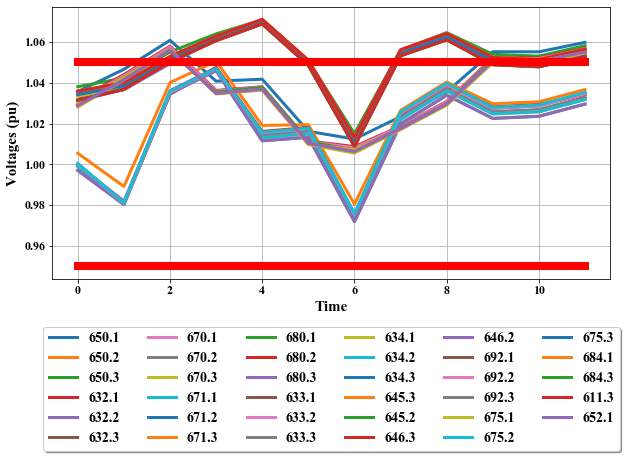

In [36]:
# Plot the OpenDSS nodal voltage results 

nodes = nodeNamesCsv

plt.figure(figsize=(10,5))
for k in range(volts_dss.shape[0]):
    plt.plot(volts_dss_sorted[k],linewidth = 3, label = nodes[k])
plt.xlabel('Time', fontsize=15)
plt.ylabel('Voltages (pu)', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 289, 12), [str(int(a/12)) for a in range(0, 289, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(lb_volts, linewidth = 8, color = 'red')
plt.plot(ub_volts, linewidth = 8, color = 'red')
#plt.ylim((0.94, 1.06))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()

In [37]:
# Total demand

Pd_tot = P_restored_t
Qd_tot  = Q_restored_t

# Total Generation

Pg_tot = Pmt_sp + Ppv_sp + Pwt_sp + Pes1_sp + Pes2_sp + Pes3_sp
Qg_tot = Qmt_sp + Qwt1_sp + Qwt2_sp + Qwt3_sp + Qpv1_sp + Qpv2_sp + Qpv3_sp + Qes1_sp + Qes2_sp + Qes3_sp

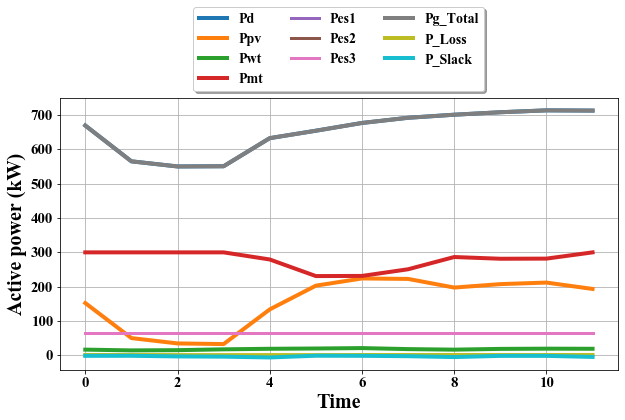

In [38]:
# Active power plot

plt.figure(figsize=(10,5))
plt.plot(Pd_tot,linewidth = 4, label = 'Pd')
plt.plot(Ppv_sp,linewidth = 4, label = 'Ppv')
plt.plot(Pwt_sp,linewidth = 4, label = 'Pwt')
plt.plot(Pmt_sp,linewidth = 4, label = 'Pmt')
plt.plot(Pes1_sp,linewidth = 3, label = 'Pes1')
plt.plot(Pes2_sp,linewidth = 3, label = 'Pes2')
plt.plot(Pes3_sp,linewidth = 3, label = 'Pes3')
plt.plot(Pg_tot,linewidth = 4, label = 'Pg_Total')
plt.plot(line_lossesP,linewidth = 4, label = 'P_Loss')
plt.plot(slackP,linewidth = 4, label = 'P_Slack')
#plt.ylim((-500, 1700))
plt.xlabel('Time', fontsize=20)
plt.ylabel('Active power (kW)', fontsize=20)
plt.tick_params(labelsize=15)
#plt.xticks(range(0, 289, 12), [str(int(a/12)) for a in range(0, 289, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.36), fancybox=True, shadow=True, ncol=3, fontsize=14)
plt.grid()
plt.show()

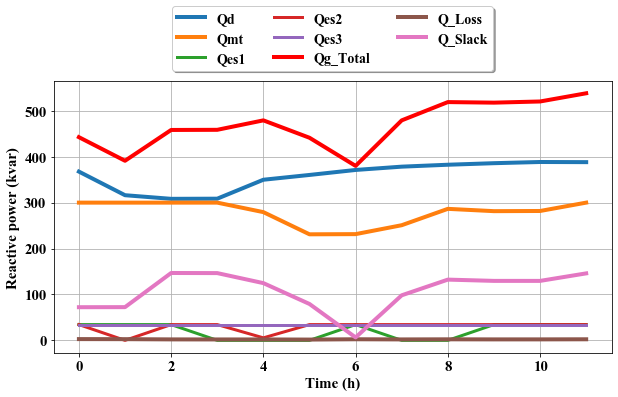

In [39]:
# Reactive Power Plot

plt.figure(figsize=(10,5))
plt.plot(Qd_tot,linewidth = 4, label = 'Qd')
plt.plot(Qmt_sp,linewidth = 4, label = 'Qmt')
plt.plot(Qes1_sp,linewidth = 3, label = 'Qes1')
plt.plot(Qes2_sp,linewidth = 3, label = 'Qes2')
plt.plot(Qes3_sp,linewidth = 3, label = 'Qes3')
plt.plot(Qg_tot,linewidth = 4, label = 'Qg_Total', color='red')
plt.plot(line_lossesQ,linewidth = 4, label = 'Q_Loss')
plt.plot(slackQ,linewidth = 4, label = 'Q_Slack')
#plt.ylim((-100, 1400))
plt.xlabel('Time (h)', fontsize=15)
plt.ylabel('Reactive power (kvar)', fontsize=15)
plt.tick_params(labelsize=15)
#plt.xticks(range(0, 289, 12), [str(int(a/12)) for a in range(0, 289, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.30), fancybox=True, shadow=True, ncol=3, fontsize=14)
plt.grid()
plt.show()

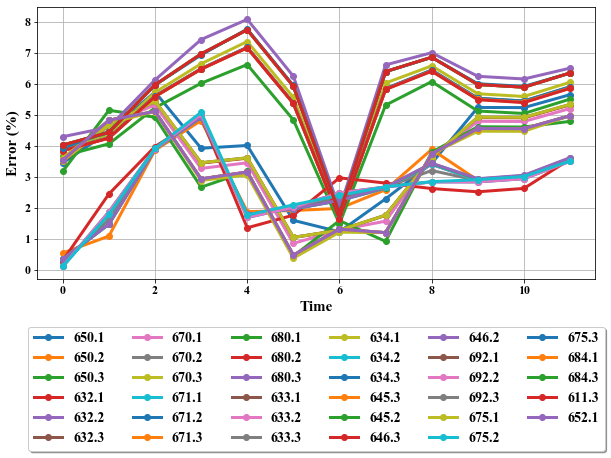

In [40]:
# Plot voltage error between MPC and DSS

voltages_dss = volts_dss_sorted
voltages_mpc = volts_mpc

err = 100*abs(voltages_dss - voltages_mpc)/voltages_dss

plt.figure(figsize=(10,5))
for k in range(err.shape[0]):
    plt.plot(err[k],linewidth = 3, label = nodes[k], marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Error (%)', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
#plt.ylim((0, 7))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()


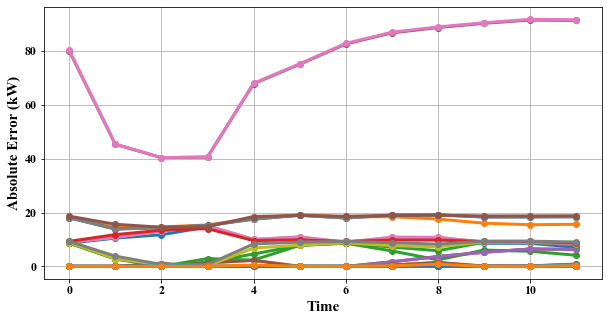

In [41]:
# Plot line flow error between MPC and DSS

err = abs(P_flow_kW_dss - P_flow_kW_mpc)

plt.figure(figsize=(10,5))
for k in range(err.shape[0]):
    plt.plot(err[k],linewidth = 3, marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Absolute Error (kW)', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
#plt.ylim((0, 7))
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()
